In [141]:
import json, os
import PIL
import cv2
import numpy as np
from skimage import morphology

def get_skeleton(img, roi_box, scale=0.5):
    img = img[roi_box[0][1]:roi_box[1][1], roi_box[0][0]:roi_box[1][0]]
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    dist_trans = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    bw_img = np.uint8(dist_trans > 0.3 * dist_trans.max()) * 255

    bw_img = cv2.resize(bw_img, np.int16(np.float32(bw_img.shape) * scale))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel, iterations=2)
    opened = cv2.bitwise_not(opened)
    
    skeleton = morphology.skeletonize(opened)
    skeleton = morphology.remove_small_holes(skeleton)
    skeleton = morphology.remove_small_objects(skeleton, min_size=10)
    result = cv2.resize(np.uint8(skeleton), bw_img.shape)

    for i in range(1, result.shape[0] - 1):
        for j in range(1, result.shape[1] - 1):
            if result[i, j - 1] != 0 or result[i, j + 1] != 0:
                result[i, j] = 0
            if result[i, j - 1] == 0 and result[i, j + 1] == 0 and result[i - 1, j] == 0 and result[i + 1, j] == 0:
                result[i, j] = 0
    
    return result

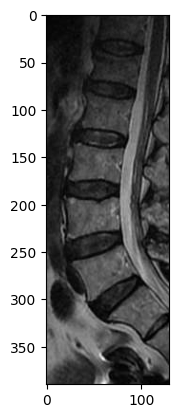

In [142]:
img_path = '../data/images/study9_image24.jpg'
img = cv2.imread(img_path)

res = get_skeleton(img, ((170, 100), (300, 490)))
import matplotlib.pyplot as plt

plt.imshow(res, cmap='gray')
plt.show()